In [13]:
# basic
import os 
import sys
import math
from time import time
import pickle

# general
import warnings
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# notebook
from IPython.display import display

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , roc_auc_score , confusion_matrix , f1_score
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Linear
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam,SGD , RMSprop

from scipy.fft import fft

import gc

from scipy import stats

from tqdm import tqdm
import copy  # to save best model parameters


In [39]:
activity_names = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic_walking', \
                  'ascending_stairs', 'descending_stairs', 'vacuum_cleaning', 'ironing', 'rope_jumping']

## Data Set & Data Loader

In [40]:
path = './train_dev_test_aug1_n20'
with open(path , 'rb') as f:
    (train, dev ,  test) = pickle.load(f)

In [41]:
def convert_pre_data(data):

    X_list = []
    y_list = []

    for d  in data:
        X_list.append(d[0])
        y_list.append(d[1])
    
    return X_list , y_list

X_train_seq , y_train_seq = convert_pre_data(train)
X_dev_seq , y_dev_seq = convert_pre_data(dev)
X_test_seq , y_test_seq = convert_pre_data(test)

X_train_seq  = torch.stack(X_train_seq , dim = 0)
X_dev_seq  = torch.stack(X_dev_seq , dim = 0)
X_test_seq  = torch.stack(X_test_seq , dim = 0)

y_train_seq    = torch.tensor(y_train_seq,dtype=torch.long)
y_dev_seq      = torch.tensor(y_dev_seq,dtype=torch.long)
y_test_seq     = torch.tensor(y_test_seq,dtype=torch.long)

X_train_seq.shape , y_train_seq.shape , X_dev_seq.shape , y_dev_seq.shape , X_test_seq.shape , y_test_seq.shape 

(torch.Size([3977, 20, 27, 13]),
 torch.Size([3977]),
 torch.Size([413, 20, 27, 13]),
 torch.Size([413]),
 torch.Size([650, 20, 27, 13]),
 torch.Size([650]))

In [42]:
def gen_data_loader(X_seq , y_seq,batch_size):
    
  #  features  = torch.tensor(X_seq,dtype=torch.float32)
  #  labels    = torch.tensor(y_seq,dtype=torch.long)     
    ds        = torch.utils.data.TensorDataset(X_seq, y_seq)
    dl        = DataLoader(ds,batch_size=batch_size,shuffle=True)
    
    return dl
    
# generate data loaders
batch_size = 64
dl_train   = gen_data_loader(X_train_seq , y_train_seq ,batch_size = batch_size)
dl_dev     = gen_data_loader(X_dev_seq , y_dev_seq ,batch_size = batch_size)
dl_test    = gen_data_loader(X_test_seq , y_test_seq ,batch_size = batch_size)

### MODEL

In [43]:
device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def clear_cache():
    gc.collect()  # garbage collector
    torch.cuda.empty_cache()

In [44]:
class Individual_Conv_single(nn.Module):
    def __init__(self ,input_size  , num_conv_layer):
        super(Individual_Conv_single, self).__init__()
        
        layers_conv = []
        layers_fc   = []
        dropout     = 0
        
        if num_conv_layer == 1:
            conv_features = 64
            layers_conv.append(nn.Conv1d(1, conv_features, 3, stride=1  , padding='same'))
            layers_conv.append(nn.Dropout(p=dropout))
            layers_conv.append(nn.BatchNorm1d(conv_features))
            layers_conv.append(nn.ReLU(inplace=True))
            layers_conv.append(nn.MaxPool1d(2, stride=2))
            
           # layers_fc.append(nn.Linear(conv_features*12, input_size))
            layers_fc.append(nn.Linear(conv_features*6, input_size)) # for FFT
        else:  # 4 layers      
            layers_conv.append(nn.Conv1d(1, 32, 3, stride=1  , padding='same'))
            layers_conv.append(nn.Dropout(p=dropout))
            layers_conv.append(nn.BatchNorm1d(32))
            layers_conv.append(nn.ReLU(inplace=True))
                
            layers_conv.append(nn.Conv1d(32, 32, 3, stride=1  , padding='same'))
            layers_conv.append(nn.Dropout(p=dropout))
            layers_conv.append(nn.BatchNorm1d(32))
            layers_conv.append(nn.ReLU(inplace=True))
            layers_conv.append(nn.MaxPool1d(2, stride=2))
        
            layers_conv.append(nn.Conv1d(32, 64, 3, stride=1  , padding='same'))
            layers_conv.append(nn.Dropout(p=dropout))
            layers_conv.append(nn.BatchNorm1d(64))
            layers_conv.append(nn.ReLU(inplace=True))
        
            layers_conv.append(nn.Conv1d(64, 64, 3, stride=1  , padding='same'))
            layers_conv.append(nn.BatchNorm1d(64))
            layers_conv.append(nn.ReLU(inplace=True))
            layers_conv.append(nn.MaxPool1d(2, stride=2))
            
           # layers_fc.append(nn.Linear(64*6, input_size))
            layers_fc.append(nn.Linear(64*3, input_size))  # for fft
        
               
        layers_fc.append(nn.ReLU(inplace=True))
            
        self.ind_conv = nn.Sequential(*layers_conv)
        self.ind_fc    = nn.Sequential(*layers_fc)
                
    def forward(self, X):  
        X_t              = X.unsqueeze(1) # input channel
        out_conv         = self.ind_conv(X_t) 
        out_conv_flat    = out_conv.view(out_conv.shape[0],-1)
        out              = self.ind_fc(out_conv_flat)
        return out

    
class Individual_Conv(nn.Module):
    def __init__(self ,num_features , input_size , num_conv_layer):
        super(Individual_Conv, self).__init__()
        
        self.num_features  = num_features
        self.module        = []
        
        for feature_num in range(num_features):
            self.module.append(Individual_Conv_single(input_size = input_size , num_conv_layer = num_conv_layer) )
              
            self.add_module("feature_{}_Individual_Conv_single".format(feature_num), \
                            self.module[feature_num])
              
    def forward(self, X): 
          
        out = []
        for feature_num in range(self.num_features):
            out.append(self.module[feature_num](X[:,feature_num,:]) )
            
        return torch.stack(out , dim=1)

In [45]:
# TEST
batch_size = 64
X = torch.tensor(X_train_seq[0:batch_size,0] ,dtype=torch.float32).to(device)
X.shape
model = Individual_Conv(num_features = X.shape[1] ,  input_size = X.shape[2] , num_conv_layer=1).to(device)
#print (model)
model(X).shape

<ipython-input-45-badf37ba30bc>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_train_seq[0:batch_size,0] ,dtype=torch.float32).to(device)


torch.Size([64, 27, 13])

In [46]:
#https://www.kaggle.com/code/mlwhiz/attention-pytorch-and-keras/notebook

class Attention(nn.Module):
    def __init__(self,  input_size):
        super(Attention, self).__init__()
        
        self.input_size = input_size
        # Linear 
        self.linear = nn.Linear(input_size, input_size)
        
        # Conext vector 
        context_weight      = torch.zeros(input_size, 1)
        nn.init.kaiming_uniform_(context_weight)
        self.context_weight = nn.Parameter(context_weight)     
     
    def forward(self, X):   # X dim (batch , feature number / step , feature_vect)
        
        num_features = X.shape[1]
        linear = []
        
        """"
        for feature_num  in range(num_features):
            feature = X[:,feature_num,:]
            l       = self.linear(feature)
            l       = torch.tanh(l)
            linear.append(l)
            
        X_linear = torch.stack(linear , dim=1)   # X_linear dimension is (Batch , feature , embedding = input_size)
        """
        
        X_linear = torch.tanh(self.linear(X))   # X_linear dimension is (Batch , feature , embedding = input_size)
                  
        eij = torch.matmul(X_linear, self.context_weight)     # eij domain is (batch , feature_num,1)

        a   = torch.exp(eij)
        
        a   = a / (torch.sum(a, dim = 1, keepdim=True) + 1e-10)
                
        weighted_input = X *a

        return torch.sum(weighted_input, 1)   

In [47]:
# TEST
batch_size = 64
X = torch.tensor(X_train_seq[0:batch_size,0] ,dtype=torch.float32).to(device)
model = Attention(input_size = X.shape[2]).to(device)
model(X).shape
print (model)

Attention(
  (linear): Linear(in_features=13, out_features=13, bias=True)
)


<ipython-input-47-d2df419e371e>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_train_seq[0:batch_size,0] ,dtype=torch.float32).to(device)


In [48]:
class AttnSense(nn.Module):
    def __init__(self,num_features,input_size , num_conv_layer , hidden_size  , AG , AF , num_classes , dropout = 0 ):
        super(AttnSense, self).__init__()
        
        self.AG = AG
        self.AF = AF
        
        self.Individual_Conv   = Individual_Conv(num_features = num_features ,   \
                                                 input_size = input_size , num_conv_layer = num_conv_layer)
        """
        if self.AF == True:
            self.Attention_stage1  = Attention(input_size = input_size)
            gru_input_size         = input_size
        else:
            gru_input_size         = input_size*num_features
        """
        if self.AF == True:
            self.Attention_stage1  = Attention(input_size = input_size)
        gru_input_size = input_size
        
        self.gru = nn.GRU(input_size = gru_input_size, hidden_size = hidden_size, \
                            num_layers = 2,  batch_first  = True , dropout = dropout , \
                            bidirectional=False)  
        
        if self.AG == True:
            self.Attention_stage2  = Attention(input_size = hidden_size)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, X):   # X dim [Batch , N (word) , feature num , input_size]
        seq_size = X.shape[1]
        Att_stage1 = []
        for seq_size_num in range(seq_size):
            # Individual Conc
            v   = self.Individual_Conv(X[:,seq_size_num,:,:])  # Take from x (batch , features , input_size) 
            
            # First layer attension
            if self.AF == True:
                att = self.Attention_stage1(v) 
            else:
                # concat all the features 
                #att = v.view(v.shape[0],-1)
                # mean
                att   = v.mean(dim = 1)
                
            Att_stage1.append(att)   
        
        C = torch.stack(Att_stage1 , dim=1)   # C results is (batch , seq_size , input_size)
        
        h_out, hn = self.gru(C)
        
        if self.AG == True:   
            delta = self.Attention_stage2(h_out)  
            #delta   = h_out[:,-1,:] 
        else:
            delta   = h_out.mean(dim = 1)
        
        out   = self.fc(delta)
             
        return out   
         

In [49]:
# TEST
batch_size = 64
X = torch.tensor(X_train_seq[0:batch_size] ,dtype=torch.float32).to(device)  
print (X.shape , X.dtype)
model = AttnSense(num_features = X.shape[2] , input_size = X.shape[3] , num_conv_layer = 4 , \
                  hidden_size = 100 , AG = True , AF = True , num_classes = len(activity_names)).to(device)
#print (model(X) ) 

torch.Size([64, 20, 27, 13]) torch.float32


<ipython-input-49-3e4e97ee4f5a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_train_seq[0:batch_size] ,dtype=torch.float32).to(device)


In [50]:
device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AttnSense(num_features = X_train_seq.shape[2] , input_size = X_train_seq.shape[3] , num_conv_layer = 4  \
                  , hidden_size = 50 , AG = True , AF = True , num_classes = len(activity_names) ).to(device)

lr = 1e-4
optimizer  = Adam(model.parameters(), lr=lr , weight_decay = 1e-4) 
#optimizer  = RMSprop(model.parameters(), lr=lr) 


## TRAIN

In [51]:
# Ref: https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification
            
def train_loop(model, optimizer , n_epochs, dl_train, dl_dev,device , early_stopping = 5,  verbose=False):
  # Loss function
  criterion = nn.CrossEntropyLoss()
 
  for e in range(1, n_epochs + 1):
    loss_train_arr   = []
    loss_dev_arr     = []
    acc_train_arr    = []
    acc_dev_arr      = []
    f1_train_arr     = []
    f1_dev_arr       = []
     
    epochs_without_improvement = 0
    best_dev_loss             = None 
    best_dev_acc              = None
    best_dev_f1               = None
    
    for epoch in range(1, n_epochs + 1):
        
        #################
        ### Train loop ##
        ################
        model.train()
        train_loss   = 0
        train_acc    = 0
        y_true       = []
        y_pred       = []
        
        for batch  in tqdm(dl_train, disable=(not verbose)):
            data , label = batch      
            # Send tensors to GPU
            data   = data.to(device)
            label  = label.to(device)            
               
            pred   = model(data)
            loss   = criterion(pred , label)
            #print ("Train " , loss.item())
                     
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()               
            # agg  batch results
            train_loss += loss.item()
            pred_cls =  np.argmax(pred.detach().to('cpu').numpy() , axis = 1)
            y_true.extend(label.detach().to('cpu').numpy())
            y_pred.extend(pred_cls) 
            
        # Agg epoch results 
        train_loss = train_loss / len(dl_train)            
        loss_train_arr.append(train_loss)        
        train_acc = accuracy_score(y_true, y_pred)          
        acc_train_arr.append(train_acc)
        train_f1  = f1_score(y_true, y_pred,sample_weight=None, average  = 'weighted' , zero_division='warn')
        f1_train_arr.append(train_f1)
   
        ####################
        # Dev  evaluation #
        ###################
        dev_loss    = 0
        dev_acc     = 0
        y_true      = []
        y_pred      = []
        
        model.eval()
        with torch.no_grad():
            for batch  in tqdm(dl_dev, disable=(not verbose)):
                data , label = batch      
                # Send tensors to GPU
                data   = data.to(device)
                label  = label.to(device)            
               
                pred   = model(data)
                loss   = criterion(pred , label)
                # Agg results
                dev_loss   += loss.item()
                pred_cls =  np.argmax(pred.detach().to('cpu').numpy() , axis = 1)
                y_true.extend(label.detach().to('cpu').numpy())
                y_pred.extend(pred_cls) 
                
            # Agg epoch results 
        dev_loss = dev_loss / len(dl_dev)         
        loss_dev_arr.append(dev_loss)    
        dev_acc = accuracy_score(y_true, y_pred)          
        acc_dev_arr.append(dev_acc)
        dev_f1  = f1_score(y_true, y_pred,sample_weight=None, average  = 'weighted' , zero_division='warn')
        f1_dev_arr.append(dev_f1)
            
        # Early Stop and best model save 
        if not best_dev_loss or dev_loss < best_dev_loss:  
        #if not best_dev_acc or dev_acc > best_dev_acc:
        #if not best_dev_f1 or dev_f1 > best_dev_f1:
            best_train_loss = train_loss
            best_dev_loss   = dev_loss
            best_train_acc  = train_acc
            best_dev_acc    = dev_acc
            best_train_f1   = train_f1
            best_dev_f1     = dev_f1
            epochs_without_improvement = 0
            #print ("Achieved lower test loss  , save model  at epoch number {} ".format(epoch + 1) )
            best_state_dict = copy.deepcopy(model.state_dict())
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement == early_stopping:
            if verbose == True:
                print ("\nEarly stoping after {} epochs. Dev loss did not imporve for more than {} epcochs".format(epoch,early_stopping))
            break
            
        #if (verbose) & (epoch % 5 == 1):   #  report every 10% of the number of epoch
        if  epoch % 5 == 1:   #  report every 10% of the number of epoch
        #if True:
            print("\nEpoch {epoch_id}".format(epoch_id=epoch))
            print("Train loss  : {:.3f}".format(train_loss),end=',   ')
            print("Dev loss    : {:.3f}".format(dev_loss))
            print("Train acc  : {:.3f}".format(train_acc),end=',   ')
            print("Dev acc    : {:.3f}".format(dev_acc))
            print("Train f1    : {:.3f}".format(train_f1),end=',   ')
            print("Dev f1    : {:.3f}".format(dev_f1))
            clear_cache()
            
                  
    # Finish  training 
    model.load_state_dict(best_state_dict)
    if (verbose):
        print('\nFinished Training:')
        print('Train loss ={:.3f}, Dev loss ={:.3f}'.format(best_train_loss ,best_dev_loss ))
        print('Train acc ={:.3f}, Dev acc ={:.3f}'.format(best_train_acc ,best_dev_acc ))
        print('Train F1 score ={:.3f}, Dev F1 score={:.3f}'.format(best_train_f1 ,best_dev_f1 ))
       
        
    return loss_train_arr[1::] , loss_dev_arr[1::] , acc_train_arr[1::] , acc_dev_arr[1::] , f1_train_arr[1::] , f1_dev_arr[1::]

In [52]:
def loss_graph(loss_train_arr , loss_dev_arr , f1_train_arr , f1_dev_arr , test_name = 'Dev'):
    fig, ax = plt.subplots(1, 2,figsize=(14, 5))

    ax[0].set_title('Loss vs Epoch')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].plot(loss_train_arr,label="Train loss")
    ax[0].plot(loss_dev_arr,  label="{} loss".format(test_name))
    ax[0].legend()
        
    ax[1].set_title('F1 score vs Epoch')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('F1 score')
    ax[1].plot(acc_train_arr,  label="Train F1")
    ax[1].plot(f1_dev_arr,  label="{} F1".format(test_name))
    ax[1].legend()    

In [ ]:
%%time

loss_train_arr , loss_dev_arr , acc_train_arr , acc_dev_arr , f1_train_arr , f1_dev_arr = \
    train_loop(model = model, optimizer = optimizer , n_epochs=60 , dl_train  = dl_train , dl_dev = dl_dev , \
               device = device , early_stopping = 10,verbose=True)

In [ ]:
loss_graph(loss_train_arr , loss_dev_arr , f1_train_arr , f1_dev_arr)

## EVALUATION

In [53]:
def evaluate(model, dl , caption, plot_cm , print_scores,  verbose=False , cm_perventage = True):
    
    if print_scores == True:
        print(caption,"\n")
        
    y_true       = []
    y_pred       = []
    
    model.eval()
    with torch.no_grad():
        for batch  in tqdm(dl, disable=(not verbose)):
            data , label = batch      
            # Send tensors to GPU
            data   = data.to(device)
            label  = label.to(device)  
               
            pred       = model(data)
            # Agg results
            pred_cls =  np.argmax(pred.detach().to('cpu').numpy() , axis = 1)
            y_true.extend(label.detach().to('cpu').numpy().tolist())
                
            y_pred.extend(pred_cls) 
    
    y_true_arr = np.array(y_true)
    y_pred_arr = np.array(y_pred)
    
    classes = np.union1d(y_true_arr, y_pred_arr)
    # tick_names = activity_names
    tick_names = [activity_names[c] for c in classes]
    ## Confusion Matrix - Multi class ## 
    if plot_cm == True:
        cnf_matrix = metrics.confusion_matrix(y_true_arr, y_pred_arr)
        if cm_perventage == True:
            cnf_matrix = cnf_matrix / cnf_matrix.sum(axis=1).reshape(-1,1)
            cnf_matrix = np.around(cnf_matrix, 2)
        fig, ax    = plt.subplots(figsize=(16, 8))
        tick_marks = np.arange(len(tick_names))
        print  (cnf_matrix.shape , len(tick_names))

        if cm_perventage == True:
            sns.heatmap(pd.DataFrame(data=cnf_matrix, index=tick_names, columns=tick_names), \
                        annot=True, cmap="Blues",fmt='g' , vmin = 0 , vmax = 1)
        else:
            sns.heatmap(pd.DataFrame(data=cnf_matrix, index=tick_names, columns=tick_names), annot=True, cmap="YlGnBu",fmt='g')
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title('Confusion Matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        
    # Scores #
    f1_s = f1_score(y_true_arr, y_pred_arr,sample_weight=None, average  = 'weighted' , zero_division='warn')
    m1 = metrics.classification_report(y_true_arr, y_pred_arr, target_names  = tick_names, output_dict=True,digits=3 , zero_division = 0 )
    
    f1_all      = m1['weighted avg']['f1-score']
        
    if print_scores == True:
        print(metrics.classification_report(y_true_arr, y_pred_arr, target_names  = tick_names,digits=3, zero_division = 0  ))
        print(f1_s)
    
    return f1_s

In [ ]:
f1_s_model_cls  = evaluate(model = model, dl = dl_test , caption = "Classifier results" ,\
                                               plot_cm = True , print_scores = True)

# TESTINGs

In [54]:
def bar_plot(f1_s_dict , title):

    f1_s_dict_sorted = dict(sorted(f1_s_dict.items(), key=lambda item: item[1]))

    figsize=(10,6)
    plt.rcParams.update({'font.size': 16})
    size = range(len(f1_s_dict_sorted))
    f, ax = plt.subplots(figsize=figsize) 
    plt.bar(size, f1_s_dict_sorted.values(), color=plt.cm.Paired(size))
    ax.set_xticklabels(f1_s_dict_sorted.keys(),rotation=45)
    ax.set_xticks(np.arange(len(f1_s_dict_sorted)))

    ax.set_title(title)

    for p in ax.patches:
        ax.annotate(str( int(p.get_height()*1000 )/1000 ), (p.get_x() * 1.010, p.get_height() * 1.010))


In [55]:
def load_data (test_sub_num):
    
    print ("\n\nsubject_test_num: {}".format(test_sub_num))
    # load file 
    path = './train_dev_test_aug1_n20_sub_{}'.format(test_sub_num)
    with open(path , 'rb') as f:
        (train, dev ,  test) = pickle.load(f)
    
    # convert 
    X_train_seq , y_train_seq = convert_pre_data(train)
    X_dev_seq , y_dev_seq = convert_pre_data(dev)
    X_test_seq , y_test_seq = convert_pre_data(test)

    X_train_seq  = torch.stack(X_train_seq , dim = 0)
    X_dev_seq    = torch.stack(X_dev_seq , dim = 0)
    X_test_seq   = torch.stack(X_test_seq , dim = 0)
    
    y_train_seq    = torch.tensor(y_train_seq,dtype=torch.long)
    y_dev_seq      = torch.tensor(y_dev_seq,dtype=torch.long)
    y_test_seq     = torch.tensor(y_test_seq,dtype=torch.long)
        
    # data loader 
    batch_size = 64
    dl_train   = gen_data_loader(X_train_seq , y_train_seq ,batch_size = batch_size)
    dl_dev     = gen_data_loader(X_dev_seq , y_dev_seq ,batch_size = batch_size)
    dl_test    = gen_data_loader(X_test_seq , y_test_seq ,batch_size = batch_size)

    return dl_train , dl_dev , dl_test


def load_and_train (test_sub_num):
    
    dl_train , dl_dev , dl_test = load_data(test_sub_num)
    
    # Model
    model = AttnSense(num_features = X_train_seq.shape[2] , input_size = X_train_seq.shape[3] , num_conv_layer = 4  \
                  , hidden_size = 50 , AG = True , AF = True , num_classes = len(activity_names) ).to(device)
    lr = 1e-4
    optimizer  = Adam(model.parameters(), lr=lr , weight_decay = 1e-4) 
    
    # train
    loss_train_arr , loss_dev_arr , acc_train_arr , acc_dev_arr , f1_train_arr , f1_dev_arr = \
    train_loop(model = model, optimizer = optimizer , n_epochs=60 , dl_train  = dl_train , dl_dev = dl_dev , \
               device = device , early_stopping = 10,verbose=False)
    
    #eval
    f1_s_model_cls  = evaluate(model = model, dl = dl_test , caption = "Classifier results" ,\
                                               plot_cm = True , print_scores = True)
    
    return  f1_s_model_cls
    

## INOVATION 1 -  Fine  Tune 

**Calibration by train on all data**

In [21]:
def split_calibrate( X_train_seq, y_train_seq ,  \
                     X_dev_seq, y_dev_seq ,   \
                     X_test_seq, y_test_seq ,\
                     split_size = 0.2 , imbalance_fix_level=10):
    
    random_state = 42
    # take from test  % and add to train 
    X_train_add_seq, X_test_cal_seq, y_train_add_seq, y_test_cal_seq = train_test_split(X_test_seq, y_test_seq, test_size=(1-split_size), random_state=random_state)

    # take same added data to train for the dev
    X_train_add_seq, X_dev_add_seq, y_train_add_seq, y_dev_add_seq = train_test_split(X_train_add_seq, y_train_add_seq, test_size=0.1, random_state=random_state)

    for i in range(imbalance_fix_level):
        X_train_cal_seq        = np.concatenate((X_train_seq , X_train_add_seq) , axis = 0 )
        y_train_cal_seq        = np.concatenate((y_train_seq ,y_train_add_seq) , axis = 0)
        X_dev_cal_seq          = np.concatenate((X_dev_seq , X_dev_add_seq) , axis = 0 )
        y_dev_cal_seq          = np.concatenate((y_dev_seq ,y_dev_add_seq) , axis = 0)

    return X_train_cal_seq ,  y_train_cal_seq , X_dev_cal_seq ,  y_dev_cal_seq , X_test_cal_seq ,  y_test_cal_seq


In [ ]:
def calibrate (test_sub_num):
    path = './train_dev_test_aug1_n20_sub_{}'.format(test_sub_num)
    with open(path , 'rb') as f:
        (train, dev ,  test) = pickle.load(f)
    
    X_train_seq , y_train_seq = convert_pre_data(train)
    X_dev_seq , y_dev_seq = convert_pre_data(dev)
    X_test_seq , y_test_seq = convert_pre_data(test)

    X_train_seq  = torch.stack(X_train_seq , dim = 0)
    X_dev_seq  = torch.stack(X_dev_seq , dim = 0)
    X_test_seq  = torch.stack(X_test_seq , dim = 0)

    y_train_seq    = torch.tensor(y_train_seq,dtype=torch.long)
    y_dev_seq      = torch.tensor(y_dev_seq,dtype=torch.long)
    y_test_seq     = torch.tensor(y_test_seq,dtype=torch.long)

    # generate data loaders
    batch_size = 64
    dl_train   = gen_data_loader(X_train_seq , y_train_seq ,batch_size = batch_size)
    dl_dev     = gen_data_loader(X_dev_seq , y_dev_seq ,batch_size = batch_size)
    dl_test    = gen_data_loader(X_test_seq , y_test_seq ,batch_size = batch_size)


    device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = AttnSense(num_features = X_train_seq.shape[2] , input_size = X_train_seq.shape[3] , num_conv_layer = 4  \
                  , hidden_size = 50 , AG = True , AF = True , num_classes = len(activity_names) ).to(device)

    lr = 1e-4
    optimizer  = Adam(model.parameters(), lr=lr , weight_decay = 1e-4)

    loss_train_arr , loss_dev_arr , acc_train_arr , acc_dev_arr , f1_train_arr , f1_dev_arr = \
        train_loop(model = model, optimizer = optimizer , n_epochs=60 , dl_train  = dl_train , dl_dev = dl_dev , \
                   device = device , early_stopping = 10,verbose=True)

    f1_s_model_cls  = evaluate(model = model, dl = dl_test , caption = "Classifier results" ,\
                                               plot_cm = True , print_scores = True)


    # split calibrate 
    X_train_cal_seq ,  y_train_cal_seq , X_dev_cal_seq ,  y_dev_cal_seq , X_test_cal_seq ,  y_test_cal_seq = \
                        split_calibrate (X_train_seq, y_train_seq ,  \
                        X_dev_seq, y_dev_seq ,   \
                        X_test_seq, y_test_seq ,\
                        split_size = 0.2 , imbalance_fix_level = 5)


    X_train_cal_seq    = torch.tensor(X_train_cal_seq,dtype=torch.float32)
    X_dev_cal_seq      = torch.tensor(X_dev_cal_seq,dtype=torch.float32)

    y_train_cal_seq    = torch.tensor(y_train_cal_seq,dtype=torch.long)
    y_dev_cal_seq      = torch.tensor(y_dev_cal_seq,dtype=torch.long)

    batch_size     = 64
    dl_train_cal   = gen_data_loader(X_train_cal_seq , y_train_cal_seq , batch_size = batch_size)
    dl_dev_cal     = gen_data_loader(X_dev_cal_seq , y_dev_cal_seq , batch_size = batch_size)
    dl_test_cal    = gen_data_loader(X_test_cal_seq , y_test_cal_seq , batch_size = batch_size)


    loss_train_arr , loss_dev_arr , acc_train_arr , acc_dev_arr , f1_train_arr , f1_dev_arr = \
        train_loop(model = model, optimizer = optimizer , n_epochs= 10 , dl_train  = dl_train_cal , dl_dev = dl_dev_cal , \
                   device = device , early_stopping = 10,verbose=True)

    f1_s_model_cls  = evaluate(model = model, dl = dl_test_cal , caption = "Classifier results" ,\
                                                   plot_cm = True , print_scores = True)

In [ ]:
for i in range (1):
    print ("\n\nNUMBER ",i)
    calibrate(106)

**Summary results**

In [52]:
col = ['subject' , 'normal' , 'calibrated']
calibrate_df_1 = pd.DataFrame(columns = col)

calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[101 ,0.73 , 0.76]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[101 ,0.69 , 0.69]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[101, 0.57 , 0.64]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[101, 0.79 , 0.85]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[101, 0.66 , 0.67]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[101, 0.72 , 0.80]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[101, 0.736 , 0.78]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[101, 0.695  ,0.665]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[101, 0.636 , 0.747]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[101, 0.692 , 0.727]],columns = col),ignore_index = True)


calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[108 ,0.65 , 0.88]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[108 ,0.81 , 0.92]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[108 ,0.88 , 0.93]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[108 ,0.827 , 0.84]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[108 ,0.855 , 0.913]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[108 ,0.724 , 0.932 ]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[108 ,0.908 ,  0.95]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[108, 0.746 , 0.808]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[108, 0.692 , 0.809]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[108, 0.89 , 0.947]],columns = col),ignore_index = True)



calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[104 ,0.92 , 0.94]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[104 ,0.79 , 0.91]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[104 ,0.935 , 0.928]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[104 ,0.942 , 0.950]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[104 ,0.857 , 0.927]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[104 ,0.91 , 0.949 ]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[104, 0.839 , 0.9]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[104, 0.775 , 0.9]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[104, 0.944 , 0.944]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[104, 0.92 , 0.956]],columns = col),ignore_index = True)

calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[102 ,0.64 , 0.91 ]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[102 ,0.9 , 0.95 ]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[102 ,0.77 , 0.93 ]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[102 ,0.805 ,  0.922]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[102 ,0.819 ,  0.897]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[102 ,0.902 , 0.943]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[102, 0.83 , 0.944 ]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[102, 0.856 , 0.888]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[102, 0.644 , 0.909]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[102, 0.888 , 0.945]],columns = col),ignore_index = True)


calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[106 ,0.9 , 0.9]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[106 ,0.823 , 0.885]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[106 ,0.888 , 0.943]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[106 ,0.864 , 0.865]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[106 ,0.892 , 0.898]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[106 ,0.87 , 0.91]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[106 ,0.92 , 0.912]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[106, 0.867 , 0.888]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[106, 0.836 , 0.870]],columns = col),ignore_index = True)
calibrate_df_1 = calibrate_df_1.append(pd.DataFrame([[106, 0.949 , 0.954]],columns = col),ignore_index = True)


calibrate_mean_df_1 = calibrate_df_1.groupby(['subject']).mean().reset_index().round(2)
calibrate_mean_df_1


,subject,normal,calibrated
0,101,0.69,0.73
1,102,0.81,0.92
2,104,0.88,0.93
3,106,0.88,0.90
4,108,0.80,0.89


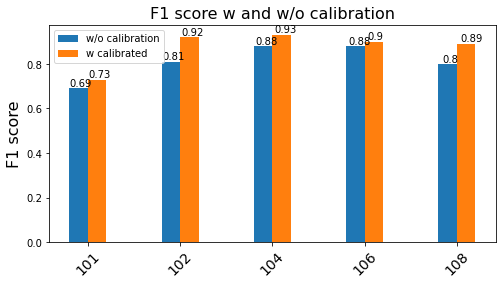

In [12]:
labels = np.unique(calibrate_mean_df_1['subject'])
x = np.arange(len(labels))


fig, ax = plt.subplots(1, 1, figsize=(8, 4))
width = 0.2
ax.bar(x - width/2, calibrate_mean_df_1['normal'] , width, label='w/o calibration')
ax.bar(x + width/2, calibrate_mean_df_1['calibrated'] , width, label='w calibrated')

ax.set_title("F1 score w and w/o calibration", fontsize=16)
ax.set_ylabel("F1 score", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels ,fontsize=14,rotation=45)
ax.legend()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.010, p.get_height() * 1.010))



**Calibration by training only on the additional data**

In [ ]:
def calibrate2 (test_sub_num):
    path = './train_dev_test_aug1_n20_sub_{}'.format(test_sub_num)
    with open(path , 'rb') as f:
        (train, dev ,  test) = pickle.load(f)
    
    X_train_seq , y_train_seq = convert_pre_data(train)
    X_dev_seq , y_dev_seq = convert_pre_data(dev)
    X_test_seq , y_test_seq = convert_pre_data(test)

    X_train_seq  = torch.stack(X_train_seq , dim = 0)
    X_dev_seq  = torch.stack(X_dev_seq , dim = 0)
    X_test_seq  = torch.stack(X_test_seq , dim = 0)

    y_train_seq    = torch.tensor(y_train_seq,dtype=torch.long)
    y_dev_seq      = torch.tensor(y_dev_seq,dtype=torch.long)
    y_test_seq     = torch.tensor(y_test_seq,dtype=torch.long)

    # generate data loaders
    batch_size = 64
    dl_train   = gen_data_loader(X_train_seq , y_train_seq ,batch_size = batch_size)
    dl_dev     = gen_data_loader(X_dev_seq , y_dev_seq ,batch_size = batch_size)
    dl_test    = gen_data_loader(X_test_seq , y_test_seq ,batch_size = batch_size)


    device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = AttnSense(num_features = X_train_seq.shape[2] , input_size = X_train_seq.shape[3] , num_conv_layer = 4  \
                  , hidden_size = 50 , AG = True , AF = True , num_classes = len(activity_names) ).to(device)

    lr = 1e-4
    optimizer  = Adam(model.parameters(), lr=lr , weight_decay = 1e-4)

    loss_train_arr , loss_dev_arr , acc_train_arr , acc_dev_arr , f1_train_arr , f1_dev_arr = \
        train_loop(model = model, optimizer = optimizer , n_epochs=60 , dl_train  = dl_train , dl_dev = dl_dev , \
                   device = device , early_stopping = 10,verbose=True)

    f1_s_model_cls  = evaluate(model = model, dl = dl_test , caption = "Classifier results" ,\
                                               plot_cm = True , print_scores = True)


    # take from test  % and add to train 
    X_train_cal_seq, X_test_cal_seq, y_train_cal_seq, y_test_cal_seq = train_test_split(X_test_seq, y_test_seq, test_size=(1-split_size), random_state=random_state)

    # Take 0.1 for dev
    X_train_cal_seq, X_dev_cal_seq, y_train_cal_seq, y_dev_cal_seq = train_test_split(X_train_cal_seq, y_train_cal_seq, test_size=0.1, random_state=random_state)



    X_train_cal_seq    = torch.tensor(X_train_cal_seq,dtype=torch.float32)
    X_dev_cal_seq      = torch.tensor(X_dev_cal_seq,dtype=torch.float32)

    y_train_cal_seq    = torch.tensor(y_train_cal_seq,dtype=torch.long)
    y_dev_cal_seq      = torch.tensor(y_dev_cal_seq,dtype=torch.long)

    batch_size     = 64
    dl_train_cal   = gen_data_loader(X_train_cal_seq , y_train_cal_seq , batch_size = batch_size)
    dl_dev_cal     = gen_data_loader(X_dev_cal_seq , y_dev_cal_seq , batch_size = batch_size)
    dl_test_cal    = gen_data_loader(X_test_cal_seq , y_test_cal_seq , batch_size = batch_size)


    loss_train_arr , loss_dev_arr , acc_train_arr , acc_dev_arr , f1_train_arr , f1_dev_arr = \
        train_loop(model = model, optimizer = optimizer , n_epochs= 10 , dl_train  = dl_train_cal , dl_dev = dl_dev_cal , \
                   device = device , early_stopping = 10,verbose=True)

    f1_s_model_cls  = evaluate(model = model, dl = dl_test_cal , caption = "Classifier results" ,\
                                                   plot_cm = True , print_scores = True)

In [27]:
def calibrate2 (test_sub_num):
    path = './train_dev_test_aug1_n20_sub_{}'.format(test_sub_num)
    with open(path , 'rb') as f:
        (train, dev ,  test) = pickle.load(f)
    
    X_train_seq , y_train_seq = convert_pre_data(train)
    X_dev_seq , y_dev_seq = convert_pre_data(dev)
    X_test_seq , y_test_seq = convert_pre_data(test)

    X_train_seq  = torch.stack(X_train_seq , dim = 0)
    X_dev_seq  = torch.stack(X_dev_seq , dim = 0)
    X_test_seq  = torch.stack(X_test_seq , dim = 0)

    y_train_seq    = torch.tensor(y_train_seq,dtype=torch.long)
    y_dev_seq      = torch.tensor(y_dev_seq,dtype=torch.long)
    y_test_seq     = torch.tensor(y_test_seq,dtype=torch.long)

    # generate data loaders
    batch_size = 64
    dl_train   = gen_data_loader(X_train_seq , y_train_seq ,batch_size = batch_size)
    dl_dev     = gen_data_loader(X_dev_seq , y_dev_seq ,batch_size = batch_size)
    dl_test    = gen_data_loader(X_test_seq , y_test_seq ,batch_size = batch_size)


    device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = AttnSense(num_features = X_train_seq.shape[2] , input_size = X_train_seq.shape[3] , num_conv_layer = 4  \
                  , hidden_size = 50 , AG = True , AF = True , num_classes = len(activity_names) ).to(device)

    lr = 1e-4
    optimizer  = Adam(model.parameters(), lr=lr , weight_decay = 1e-4)

    loss_train_arr , loss_dev_arr , acc_train_arr , acc_dev_arr , f1_train_arr , f1_dev_arr = \
        train_loop(model = model, optimizer = optimizer , n_epochs=60 , dl_train  = dl_train , dl_dev = dl_dev , \
                   device = device , early_stopping = 10,verbose=True)

    f1_s_model_cls  = evaluate(model = model, dl = dl_test , caption = "Classifier results" ,\
                                               plot_cm = True , print_scores = True)

    split_size = 0.2
    random_state = 42
    # take from test  
    X_train_cal_seq, X_test_cal_seq, y_train_cal_seq, y_test_cal_seq = train_test_split(X_test_seq, y_test_seq, test_size=(1-split_size), random_state=random_state)

    # Take 0.1 for dev
    X_train_cal_seq, X_dev_cal_seq, y_train_cal_seq, y_dev_cal_seq = train_test_split(X_train_cal_seq, y_train_cal_seq, test_size=0.1, random_state=random_state)



    X_train_cal_seq    = torch.tensor(X_train_cal_seq,dtype=torch.float32)
    X_dev_cal_seq      = torch.tensor(X_dev_cal_seq,dtype=torch.float32)

    y_train_cal_seq    = torch.tensor(y_train_cal_seq,dtype=torch.long)
    y_dev_cal_seq      = torch.tensor(y_dev_cal_seq,dtype=torch.long)

    batch_size     = 64
    dl_train_cal   = gen_data_loader(X_train_cal_seq , y_train_cal_seq , batch_size = batch_size)
    dl_dev_cal     = gen_data_loader(X_dev_cal_seq , y_dev_cal_seq , batch_size = batch_size)
    dl_test_cal    = gen_data_loader(X_test_cal_seq , y_test_cal_seq , batch_size = batch_size)


    loss_train_arr , loss_dev_arr , acc_train_arr , acc_dev_arr , f1_train_arr , f1_dev_arr = \
        train_loop(model = model, optimizer = optimizer , n_epochs= 100 , dl_train  = dl_train_cal , dl_dev = dl_dev_cal , \
                   device = device , early_stopping = 10,verbose=True)

    f1_s_model_cls  = evaluate(model = model, dl = dl_test_cal , caption = "Classifier results" ,\
                                                   plot_cm = True , print_scores = True)

In [51]:
col = ['subject' , 'normal' , 'calibrated']
calibrate_df_2 = pd.DataFrame(columns = col)


calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[101 , 0.74 , 0.871]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[101 , 0.722, 0.929]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[101, 0.698 , 0.901]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[101, 0.709 , 0.952 ]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[101,  0.759, 0.934]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[101,  0.656 , 0.911]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[101,  0.593 , 0.867]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[101,  0.746 , 0.885]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[101,  0.783 , 0.857]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[101,  0.783 , 0.857]],columns = col),ignore_index = True)


calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[108 , 0.932 , 0.936 ]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[108 , 0.944, 0.954]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[108 , 0.772, 0.904 ]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[108 ,0.806 ,0.885 ]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[108 , 0.853, 0.931]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[108 , 0.853, 0.931]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[108 , 0.826 , 0.958]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[108 ,0.873 , 0.936]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[108 , 0.894 , 0.934 ]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[108 , 0.699, 0.941]],columns = col),ignore_index = True)
#calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[108 , 0.922, 0.941]],columns = col),ignore_index = True)


calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[104 , 0.84 ,  0.938]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[104 , 0.914, 0.930]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[104 , 0.786, 0.823]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[104 , 0.805, 0.962]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[104 ,0.915 , 0.962]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[104 ,0.834 , 0.887]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[104 ,0.892 , 0.929]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[104 ,0.837 , 0.94]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[104 ,0.928 , 0.95]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[104 ,0.926 , 0.935]],columns = col),ignore_index = True)


calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[102 ,0.88 , 0.933]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[102 , 0.67,  0.931]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[102 , 0.867, 0.941]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[102 ,0.893 , 0.928 ]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[102 , 0.758, 0.93 ]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[102 ,0.767 , 0.938 ]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[102 ,0.797 , 0.897]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[102 ,0.73 , 0.896]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[102 ,0.694 , 0.84]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[102 ,0.844 , 0.939]],columns = col),ignore_index = True)


calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[106 , 0.852 , 0.943 ]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[106 ,0.917 , 0.899]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[106 ,0.878 , 0.934]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[106 ,0.763 , 0.912]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[106 ,0.893 , 0.936 ]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[106 ,0.883 , 0.928]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[106 ,0.933 , 0.942]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[106 , 0.908 , 0.918]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[106 , 0.894 , 0.931]],columns = col),ignore_index = True)
calibrate_df_2 = calibrate_df_2.append(pd.DataFrame([[106 , 0.894 , 0.9]],columns = col),ignore_index = True)


calibrate_mean_df_2 = calibrate_df_2.groupby(['subject']).mean().reset_index().round(2)
calibrate_mean_df_2


,subject,normal,calibrated
0,101,0.72,0.90
1,102,0.79,0.92
2,104,0.87,0.93
3,106,0.88,0.92
4,108,0.85,0.93


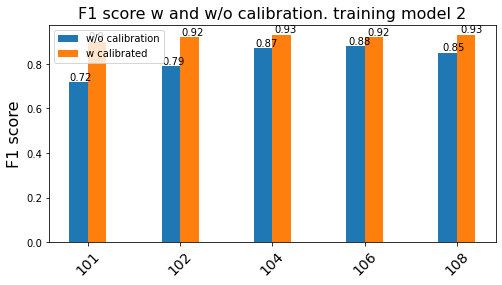

In [14]:
labels = np.unique(calibrate_mean_df_2['subject'])
x = np.arange(len(labels))


fig, ax = plt.subplots(1, 1, figsize=(8, 4))
width = 0.2
ax.bar(x - width/2, calibrate_mean_df_2['normal'] , width, label='w/o calibration')
ax.bar(x + width/2, calibrate_mean_df_2['calibrated'] , width, label='w calibrated')

ax.set_title("F1 score w and w/o calibration. training model 2", fontsize=16)
ax.set_ylabel("F1 score", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels ,fontsize=14,rotation=45)
ax.legend()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.010, p.get_height() * 1.010))



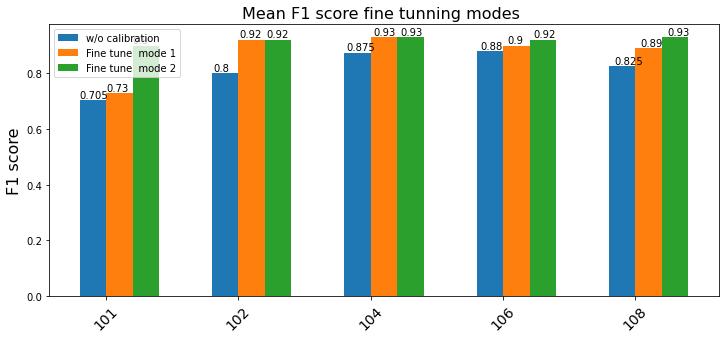

In [9]:
normal      = (calibrate_mean_df_1['normal'] + calibrate_mean_df_2['normal']) /2

labels = np.unique(calibrate_mean_df_2['subject'])
x = np.arange(len(labels))

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
width = 0.2
ax.bar(x - width/2, normal , width, label='w/o calibration')
ax.bar(x + width/2, calibrate_mean_df_1['calibrated'] , width, label='Fine tune  mode 1')
ax.bar(x + 3*width/2, calibrate_mean_df_2['calibrated'] , width, label='Fine tune  mode 2')

ax.set_title("Mean F1 score fine tunning modes ", fontsize=16)
ax.set_ylabel("F1 score", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels ,fontsize=14,rotation=45)
ax.legend()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.010, p.get_height() * 1.010))

    

In [10]:
calibrate_mode_1_subjects_df = pd.DataFrame(columns = labels)
calibrate_mode_2_subjects_df = pd.DataFrame(columns = labels)

for subject_df in calibrate_df_1.groupby(['subject']):
    calibrate_mode_1_subjects_df[subject_df[0]] = subject_df[1]['calibrated'].values
    
for subject_df in calibrate_df_2.groupby(['subject']):
    calibrate_mode_2_subjects_df[subject_df[0]] = subject_df[1]['calibrated'].values


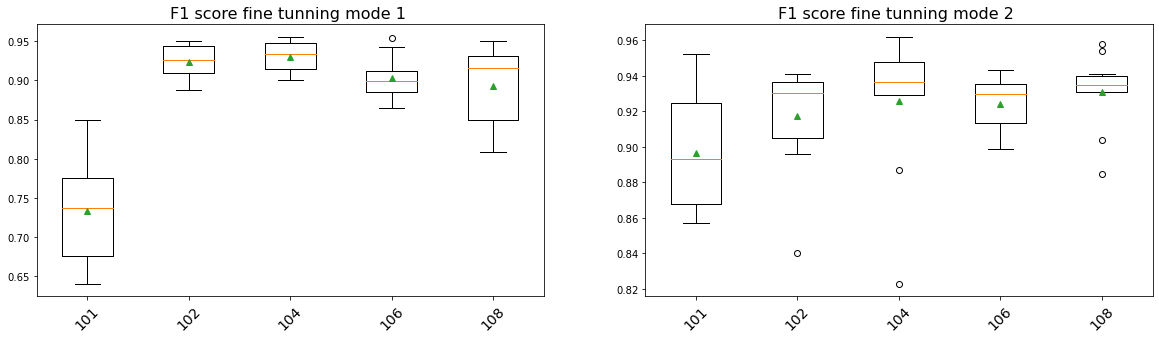

In [136]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].boxplot(calibrate_mode_1_subjects_df.values, showfliers=True, showmeans=True)
ax[0].set_title("F1 score fine tunning mode 1 ", fontsize=16)
ax[0].set_xticklabels(labels ,fontsize=14,rotation=45)
ax[1].boxplot(calibrate_mode_2_subjects_df.values, showfliers=True, showmeans=True)
ax[1].set_title("F1 score fine tunning mode 2 ", fontsize=16)
ax[1].set_xticklabels(labels ,fontsize=14,rotation=45)
print ("")

In [126]:
calibrate_df_1.insert(loc =calibrate_df_1.shape[1] , column = 'train_mode' , value = 1)
calibrate_df_2.insert(loc =calibrate_df_2.shape[1] , column = 'train_mode' , value = 2)

calibrate_df_all = pd.concat( (calibrate_df_1 , calibrate_df_2)  ,axis = 0).reset_index() 


Text(0.5, 1.0, 'F1 score fine tunning modes ')

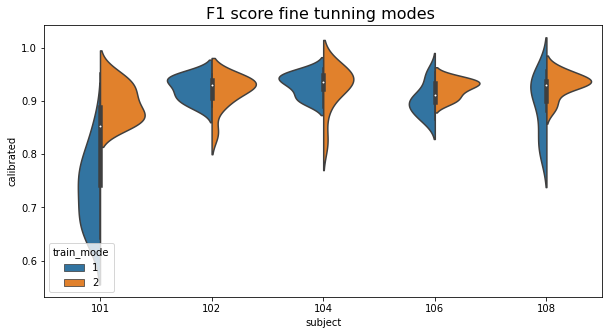

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.violinplot(x = 'subject', y='calibrated', hue="train_mode", data=calibrate_df_all,split=True)
ax.set_title("F1 score fine tunning modes ", fontsize=16)


In [54]:
for subject_df in calibrate_df_1.groupby(['subject']):
    normal_vector     = subject_df[1]['normal'].values
    calibrate_vector  = subject_df[1]['calibrated'].values
    #r1 , p1 = stats.ttest_ind(a = normal_vector, b=calibrate_vector) # not paired
    r1 , p1 = stats.ttest_rel(a = normal_vector, b=calibrate_vector)  # paired 
   # r2 , p2 = stats.ranksums(x = normal_vector, y=calibrate_vector)   # not paired
    r2 , p2 = stats.wilcoxon(x = normal_vector, y=calibrate_vector)  # paired 
    stats.wilcoxon
    print ("subject {}   t-test {:.5f}   WRS {:.5f}".format(subject_df[0] , p1, p2))

subject 101   t-test 0.01218   WRS 0.01516
subject 102   t-test 0.00213   WRS 0.00195
subject 104   t-test 0.01100   WRS 0.01086
subject 106   t-test 0.02224   WRS 0.02840
subject 108   t-test 0.00253   WRS 0.00195


In [32]:
for subject_df in calibrate_df_2.groupby(['subject']):
    normal_vector     = subject_df[1]['normal'].values
    calibrate_vector  = subject_df[1]['calibrated'].values
    #r1 , p1 = stats.ttest_ind(a = normal_vector, b=calibrate_vector) # not paired
    r1 , p1 = stats.ttest_rel(a = normal_vector, b=calibrate_vector)  # paired 
   # r2 , p2 = stats.ranksums(x = normal_vector, y=calibrate_vector)   # not paired
    r2 , p2 = stats.wilcoxon(x = normal_vector, y=calibrate_vector)  # paired 
    stats.wilcoxon
    print ("subject {}   t-test {:.5f}   WRS {:.5f}".format(subject_df[0] , p1, p2))

subject 101   t-test 0.00003   WRS 0.00195
subject 102   t-test 0.00024   WRS 0.00195
subject 104   t-test 0.00366   WRS 0.00195
subject 106   t-test 0.02084   WRS 0.01367
subject 108   t-test 0.00370   WRS 0.00195


## INOVATION 2 -  Multi Head Attention

In [56]:
def mh_level(test_sub_num):
    dl_train , dl_dev , dl_test = load_data(test_sub_num) 
    f1_s_mh_dict = {}
    
    for multi_head_att_num in [2,3,4 , 6]:
    
        k = 'MH_level_{}'.format(multi_head_att_num)
        print ("\n\n",k)
        lr = 1e-4
        model_MH = AttnSense_MH(num_features = X_train_seq.shape[2] , input_size = X_train_seq.shape[3] , num_conv_layer = 4 , \
                    MH_Feature = True , MH_GRU = True , \
                    multi_head_att_num = multi_head_att_num , hidden_size = 60 , AG = True , num_classes = len(activity_names) ).to(device)
    
        optimizer  = Adam(model_MH.parameters(), lr=lr , weight_decay = 1e-4) 
    
        # train
        loss_train_arr , loss_dev_arr , acc_train_arr , acc_dev_arr , f1_train_arr , f1_dev_arr = \
        train_loop(model = model_MH, optimizer = optimizer , n_epochs=60 , dl_train  = dl_train , dl_dev = dl_dev , \
               device = device , early_stopping = 10,verbose=False)
    
        #eval
        f1_s_mh_dict[k]  = evaluate(model = model_MH, dl = dl_test , caption = "Classifier results" ,\
                                                   plot_cm = True , print_scores = True)
    
    return f1_s_mh_dict

In [57]:
class Multi_Head_Attention(nn.Module):
    def __init__(self,  input_size , multi_head_att_num):
        super(Multi_Head_Attention, self).__init__()
        
        self.multi_head_att_num = multi_head_att_num
        self.input_size         = input_size
        
        self.multi_head_layer = []
        for i  in range(multi_head_att_num):
            self.multi_head_layer.append(Attention(input_size))
            self.add_module("multi_head_layer_{}".format(i), self.multi_head_layer[-1])
                
        # Linear 
        self.linear = nn.Linear(multi_head_att_num* input_size, input_size)
           
    def forward(self, X): 
        out_att = []
        for i  in range(self.multi_head_att_num):
            out_att.append(self.multi_head_layer[i](X))
        
        out_att_flat = torch.stack(out_att , dim=1).view(X.shape[0],-1)  # batch size , 25
        
        out = self.linear(out_att_flat)
        
        return out

In [58]:
class AttnSense_MH(nn.Module):
    def __init__(self,num_features,input_size , num_conv_layer , MH_Feature , MH_GRU , \
                 multi_head_att_num , \
                 hidden_size  , AG , num_classes , dropout = 0 ):
        super(AttnSense_MH, self).__init__()
        
        self.AG = AG
        
        self.Individual_Conv   = Individual_Conv(num_features = num_features ,   \
                                                 input_size = input_size , num_conv_layer = num_conv_layer)
        if MH_Feature == True:
            self.Attention_stage1  = Multi_Head_Attention(input_size = input_size ,multi_head_att_num = multi_head_att_num)
        else:
            self.Attention_stage1  = Attention(input_size = input_size)

        
        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, \
                            num_layers = 2,  batch_first  = True , dropout = dropout , \
                            bidirectional=False)  
        
        if MH_GRU == True:
            self.Attention_stage2  = Multi_Head_Attention(input_size = hidden_size,multi_head_att_num = multi_head_att_num)
        elif self.AG == True:
            self.Attention_stage2  = Attention(input_size = input_size)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, X):   # X dim [Batch , N (word) , feature num , input_size]
        seq_size = X.shape[1]
        Att_stage1 = []
        for seq_size_num in range(seq_size):
            # Individual Conc
            v   = self.Individual_Conv(X[:,seq_size_num,:,:])  # Take from x (batch , features , input_size) 
            # First layer attension
            att = self.Attention_stage1(v) 
            Att_stage1.append(att)   
        
        C = torch.stack(Att_stage1 , dim=1)   # C results is (batch , seq_size , input_size)
        
        h_out, hn = self.gru(C)
        
        if self.AG == True:   
            delta = self.Attention_stage2(h_out)  
            #delta   = h_out[:,-1,:] 
        else:
            delta   = h_out.mean(dim = 1)
        
        out   = self.fc(delta)
             
        return out   
      

In [ ]:
mh_level(106)

**MH Summary**

In [36]:
col = ['subject' , 'MH Level 1' , 'MH Level 2' , 'MH Level 3' , 'MH Level 4' , 'MH Level 6' ]
mh_df = pd.DataFrame(columns = col)

mh_df = mh_df.append(pd.DataFrame([[101 ,0.693 , 0.75 , 0.77 , 0.85 , 0.62]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[101 ,0.693 , 0.78 , 0.87 , 0.69 , 0.74 ]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[101 ,0.693 , 0.69, 0.76 , 0.76 ,  0.73]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[101 ,0.693 , 0.75 , 0.62 , 0.76 , 0.72]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[101 ,0.693 , 0.614 , 0.731 , 0.636 , 0.735]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[101 ,0.693 , 0.667 , 0.662 , 0.636 , 0.735]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[101 ,0.693 ,0.729 , 0.72 ,  0.77  , 0.66]]  ,columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[101 ,0.693 ,0.710 ,0.732 , 0.623  , 0.725]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[101 ,0.693 ,0.731 , 0.743 , 0.752 , 0.678]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[101 ,0.693 ,0.758 , 0.737 , 0.804 , 0.708]],columns = col),ignore_index = True)


mh_df = mh_df.append(pd.DataFrame([[108 ,0.79 , 0.65 , 0.74 , 0.91 , 0.72]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[108 ,0.79 , 0.83 , 0.76 , 0.79 , 0.78 ]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[108 ,0.79, 0.81 ,  0.87 , 0.73 ,0.75 ]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[108 ,0.79 , 0.75 ,  0.81 , 0.83 , 0.93]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[108 ,0.79 , 0.66 ,  0.75 , 0.89 , 0.92]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[108 ,0.79 , 0.9 ,  0.736 , 0.762 , 0.742]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[108 ,0.79 , 0.767 , 0.904 , 0.744 , 0.845]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[108 ,0.79 , 0.918 , 0.809 , 0.892 , 0.848]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[108 ,0.79 , 0.874 , 0.944 , 0.702 , 0.754]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[108 ,0.79 , 0.66  , 0.68  , 0.75 , 0.86]],columns = col),ignore_index = True)

mh_df = mh_df.append(pd.DataFrame([[104 , 0.892 , 0.91 ,  0.92 , 0.93 , 0.92]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[104 , 0.892 , 0.86 , 0.88 , 0.95 , 0.93]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[104 , 0.892 , 0.902 , 0.935, 0.84 , 0.88 ]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[104 , 0.892 , 0.836 , 0.93 , 0.88 , 0.947 ]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[104 , 0.892 , 0.848 , 0.841 , 0.899 , 0.899]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[104 , 0.892 , 0.913 , 0.925 , 0.923 , 0.922 ]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[104 , 0.892 , 0.907 , 0.775 , 0.913 , 0.926 ]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[104 , 0.892 , 0.760  ,0.901 , 0.896 , 0.822 ]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[104 , 0.892 , 0.952  , 0.955 , 0.841 , 0.952 ]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[104 , 0.892 , 0.875 , 0.930 , 0.797 , 0.930 ]],columns = col),ignore_index = True)


mh_df = mh_df.append(pd.DataFrame([[106 ,0.89 , 0.91  , 0.89  , 0.9   , 0.9]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[106 ,0.89 , 0.92  , 0.92  , 0.93  , 0.89 ]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[106 ,0.89 , 0.934 , 0.877 , 0.914 , 0.937 ]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[106 ,0.89 , 0.921 , 0.932 , 0.868 , 0.962]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[106 ,0.89 , 0.913 , 0.876 , 0.941 , 0.950]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[106 ,0.89 , 0.934 , 0.917 , 0.846 , 0.92]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[106 ,0.89 ,0.857 , 0.818 , 0.912 , 0.925]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[106 ,0.89 , 0.912 , 0.919 , 0.922 , 0.910]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[106 ,0.89 , 0.884 , 0.877 , 0.826 , 0.929]],columns = col),ignore_index = True)
mh_df = mh_df.append(pd.DataFrame([[106 ,0.89 , 0.923 , 0.824 , 0.903 , 0.901]],columns = col),ignore_index = True)



In [80]:
mh_df.head()

,subject,MH Level 1,MH Level 2,MH Level 3,MH Level 4,MH Level 6
0,101,0.693,0.750,0.770,0.850,0.620
1,101,0.693,0.780,0.870,0.690,0.740
2,101,0.693,0.690,0.760,0.760,0.730
3,101,0.693,0.750,0.620,0.760,0.720
4,101,0.693,0.614,0.731,0.636,0.735


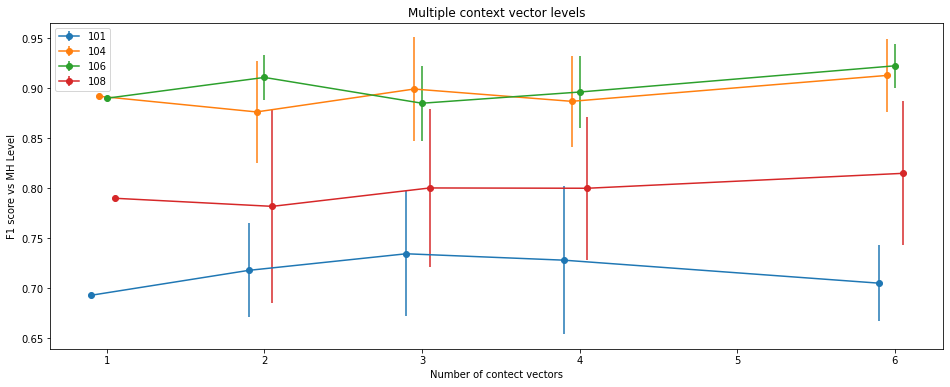

In [81]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))  
axes.set_xlabel('Number of contect vectors')
axes.set_ylabel('F1 score vs MH Level')
axes.set_title('Multiple context vector levels')
for num , df in enumerate(mh_df.groupby(['subject'] )):
    df_no_sub = df[1].drop(['subject'], axis = 1)
    y = df_no_sub.mean(axis = 0).values
   # yerr_hi = np.max(y - df_no_sub.values , axis = 0)
   # yerr_lo = np.max(df_no_sub.values-y , axis = 0)
    yerr_hi = np.std(df_no_sub.values , axis = 0)
    yerr_lo = np.std(df_no_sub.values , axis = 0)
    yerr    = [yerr_hi , yerr_lo]
    axes.errorbar(x = np.array([1,2,3,4,6]) + 0.05*num-0.1, y = y  , yerr = yerr , marker = 'o' , label = df[0])
    axes.legend()

In [65]:
for num , df in enumerate(mh_df.groupby(['subject'] )):
    df_no_sub = df[1].drop(['subject'], axis = 1)
    normal_vector1  = calibrate_df_1[calibrate_df_1['subject'] == df[0]]['normal'].values
    normal_vector2  = calibrate_df_2[calibrate_df_2['subject'] == df[0]]['normal'].values
    normal_vector   = np.hstack((normal_vector1,normal_vector2))
   # print (normal_vector)
    mh3_vector     = df_no_sub['MH Level 3'].values
    r1 , p1 = stats.ttest_ind(a = normal_vector, b=mh3_vector) # not paired
    r2 , p2 = stats.ranksums(x = normal_vector, y=mh3_vector)   # not paired
    print ("subject {}   t-test {:.5f}   WRS {:.5f}".format(df[0] , p1, p2))

subject 101   t-test 0.23386   WRS 0.24368
subject 104   t-test 0.28742   WRS 0.21801
subject 106   t-test 0.81192   WRS 0.89500
subject 108   t-test 0.51430   WRS 0.45452


In [82]:
mh_mean_df = mh_df.groupby(['subject']).mean().reset_index().round(2)
mh_mean_df

,subject,MH Level 1,MH Level 2,MH Level 3,MH Level 4,MH Level 6
0,101,0.69,0.72,0.73,0.73,0.71
1,104,0.89,0.88,0.90,0.89,0.91
2,106,0.89,0.91,0.88,0.90,0.92
3,108,0.79,0.78,0.80,0.80,0.81


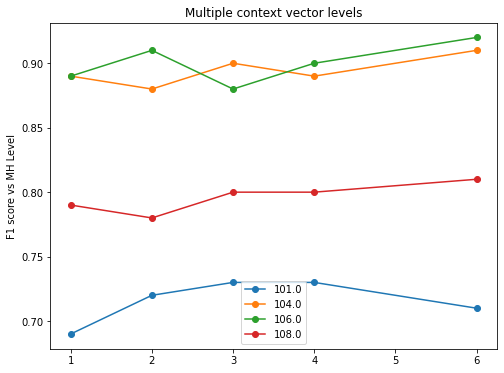

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))  
axes.set_title('Multiple context vector levels')
axes.set_ylabel('F1 score vs MH Level')
axes.set_title('Multiple context vector levels')
for row in mh_mean_df.iterrows():
    axes.plot([1,2,3,4,6], row[1][1:], label = row[1][0] ,marker = "o")
    axes.legend()

